In [2]:
import sqlite3 as sql
import pandas as pd
import spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import tqdm
import tqdm as notebook_tqdm
from textblob import TextBlob
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jaysh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Fetching

In [3]:
# Connection with the database
def connect_to_db(db_path):
    try:
        conn = sql.connect(db_path)
        return conn
    except Exception as e:
        print(f"Error connecting to database: {e}")
        return None

# Fetch the data from the database
def fetch_text_data(conn):
    if conn is None:
        return pd.DataFrame()  # Return an empty DataFrame if connection failed
    query = 'SELECT * from content,links WHERE content.id = links.id'
    df = pd.read_sql_query(query, conn)
    return df

# Use the absolute path to the database file
db_path = 'C:/Users/jaysh/Documents/TFG/Code/data/processed/articles.db'
conn = connect_to_db(db_path)
df = fetch_text_data(conn)

if not df.empty:
    print('Data fetched from the database.')
        # Drop the duplicate 'id' column (assuming the second one is redundant)
    df = df.loc[:, ~df.columns.duplicated()]

    # Convert 'publish_date' to datetime format
    df["publish_date"] = pd.to_datetime(df["publish_date"])

    # Check the cleaned DataFrame
    print(df.info())

else:
    print("No data fetched from the database.")

Data fetched from the database.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3832 entries, 0 to 3831
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              3832 non-null   int64         
 1   title           3832 non-null   object        
 2   publish_date    3832 non-null   datetime64[ns]
 3   text            3832 non-null   object        
 4   outlier         3832 non-null   int64         
 5   truncated_text  3832 non-null   object        
 6   tokens          3832 non-null   object        
 7   clean_text      3832 non-null   object        
 8   clean_title     3832 non-null   object        
 9   newspaper       3832 non-null   object        
 10  url             3832 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 329.4+ KB
None


# LABELS

 ## ANALISIS DE SENTIMIENTO


In [4]:
from textblob import TextBlob

# Function to get sentiment score
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity  # -1 (negative) to +1 (positive)

df["sentiment_score"] = df["clean_text"].apply(get_sentiment)

# Define a function to classify sentiment
def classify_sentiment(score):
    if score > 0.2:
        return "POS"
    elif score < -0.2:
        return "NEG"
    else:
        return "NEU"

df["sentiment"] = df["sentiment_score"].apply(classify_sentiment)

# Print first 10 results
print(df[["clean_text", "sentiment_score", "sentiment"]].head(10))


                                          clean_text  sentiment_score  \
0  presidente joe biden terminando mandato todaví...         0.083333   
1  vida sucede línea recta veces enmaraña luchar ...        -0.052273   
2  saliendo chicos mayores después tiempo centro ...         0.009524   
3  mismo día lalachus mostró estampa vaquilla gra...        -0.100000   
4  primer disparo batalla donald trump ciudades s...         0.177451   
5  cámara representantes aprobó martes proyecto l...         0.112121   
6  rescate madre migrante hijo nacido travesía ru...         0.000000   
7  refugios organizaciones brindan atención migra...         0.066667   
8  papa francisco elegido cardenal robert mcelroy...         0.250000   
9  niños migrantes méxico cada vez comunes último...         0.266667   

  sentiment  
0       NEU  
1       NEU  
2       NEU  
3       NEU  
4       NEU  
5       NEU  
6       NEU  
7       NEU  
8       POS  
9       POS  


In [5]:
print(df["sentiment_score"].describe())

count    3832.000000
mean        0.039364
std         0.187481
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.100000
max         0.900000
Name: sentiment_score, dtype: float64


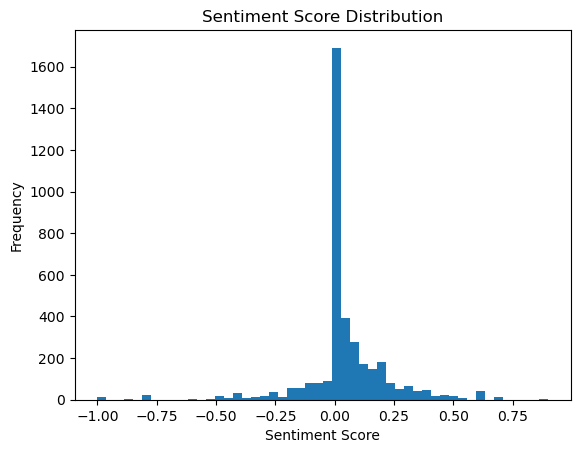

In [6]:
plot = df["sentiment_score"].plot(kind='hist', bins=50, title="Sentiment Score Distribution")
plot.set_xlabel("Sentiment Score")      
plot.set_ylabel("Frequency")
plt.show()

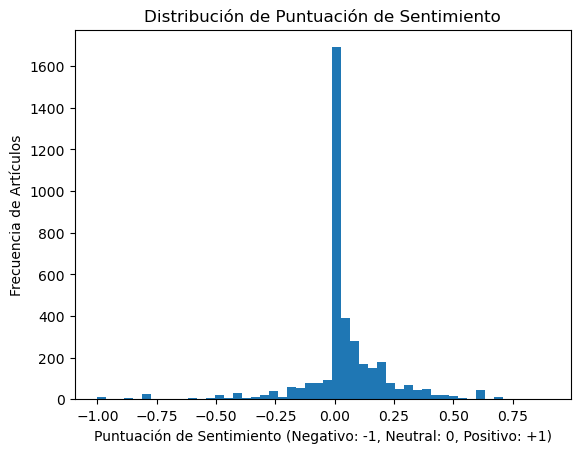

In [7]:
import matplotlib.pyplot as plt

# Plot histogram
plot = df["sentiment_score"].plot(kind='hist', bins=50, title="Distribución de Puntuación de Sentimiento")

# Improved axis labels with explanations
plot.set_xlabel("Puntuación de Sentimiento (Negativo: -1, Neutral: 0, Positivo: +1)")
plot.set_ylabel("Frecuencia de Artículos")

# Show plot
plt.show()


## LEXICON ANALYSIS

In [8]:
# Define Spanish Lexicons
pro_immigration_words = {
    "refugiado", "solidaridad", "humanitario", "derechos", "asilo",
    "acogida", "integración", "beneficio", "protección", "inclusión",
    "tolerancia", "convivencia", "hospitalidad", "multicultural", "diversidad",
    "ayuda", "bienestar", "cooperación", "derechos humanos", "seguridad social"
}


anti_immigration_words = {
    "crisis", "delito", "ilegal", "amenaza", "colapso",
    "avalancha", "extranjero", "criminal", "invasión", "delincuencia",
    "saturación", "problema migratorio", "descontrol", "violencia", "abusos",
    "peligro", "expulsión", "mafias", "irregular", "marea migratoria"
}

# Function to Count Lexicon Words
def lexicon_analysis(text):
    words = set(text.split())  # Convert text into a set of words
    pro_count = sum(word in pro_immigration_words for word in words)
    anti_count = sum(word in anti_immigration_words for word in words)
    
    return pro_count, anti_count

# Apply function to all articles
df["pro_immigration_count"], df["anti_immigration_count"] = zip(*df["clean_text"].apply(lexicon_analysis))

# Print first 10 results
print(df[["clean_text", "pro_immigration_count", "anti_immigration_count"]].head(10))


                                          clean_text  pro_immigration_count  \
0  presidente joe biden terminando mandato todaví...                      1   
1  vida sucede línea recta veces enmaraña luchar ...                      1   
2  saliendo chicos mayores después tiempo centro ...                      2   
3  mismo día lalachus mostró estampa vaquilla gra...                      0   
4  primer disparo batalla donald trump ciudades s...                      1   
5  cámara representantes aprobó martes proyecto l...                      0   
6  rescate madre migrante hijo nacido travesía ru...                      0   
7  refugios organizaciones brindan atención migra...                      3   
8  papa francisco elegido cardenal robert mcelroy...                      1   
9  niños migrantes méxico cada vez comunes último...                      1   

   anti_immigration_count  
0                       4  
1                       0  
2                       1  
3                 

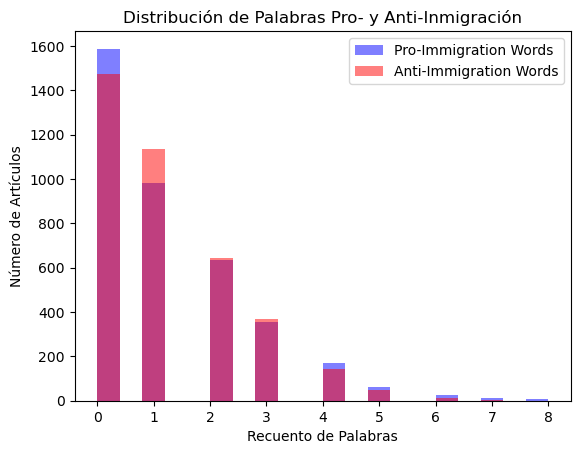

In [9]:
import matplotlib.pyplot as plt

# Plot Distribution of Pro- and Anti-Immigration Words
plt.hist(df["pro_immigration_count"], bins=20, alpha=0.5, label="Pro-Immigration Words", color="blue")
plt.hist(df["anti_immigration_count"], bins=20, alpha=0.5, label="Anti-Immigration Words", color="red")
plt.legend()
plt.xlabel("Recuento de Palabras")
plt.ylabel("Número de Artículos")
plt.title("Distribución de Palabras Pro- y Anti-Inmigración")
plt.show()


## ANALISIS DE POSTURA

In [10]:
# Function to Detect Stance Based on Word Counts
def detect_stance(pro_count, anti_count):
    if pro_count > anti_count:
        return "PRO"
    elif anti_count > pro_count:
        return "ANTI"
    else:
        return "NEU"

df["stance"] = df.apply(lambda row: detect_stance(row["pro_immigration_count"], row["anti_immigration_count"]), axis=1)

# Print Stance Distribution
print(df["stance"].value_counts())


stance
NEU     1360
ANTI    1254
PRO     1218
Name: count, dtype: int64


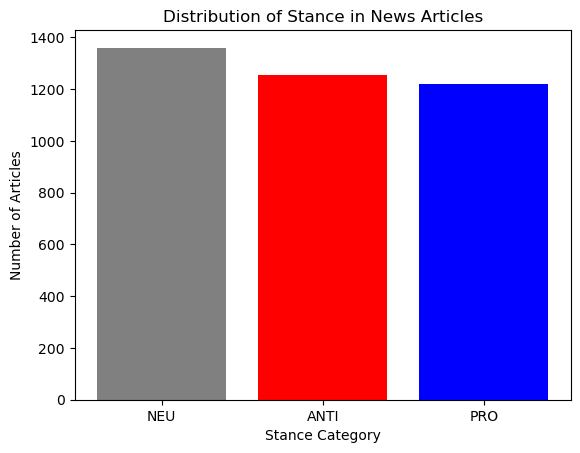

In [11]:
import matplotlib.pyplot as plt

# Count stance occurrences
stance_counts = df["stance"].value_counts()

# Create a bar chart
plt.bar(stance_counts.index, stance_counts.values, color=["gray", "red", "blue"])
plt.xlabel("Stance Category")
plt.ylabel("Number of Articles")
plt.title("Distribution of Stance in News Articles")

# Show the plot
plt.show()


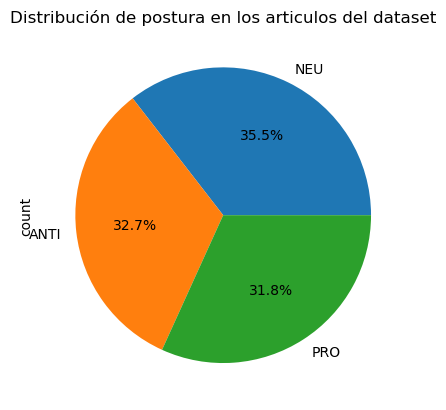

In [12]:
plot = df["stance"].value_counts().plot(kind='pie', title="Distribución de postura en los articulos del dataset", autopct='%1.1f%%')
plt.show()

In [13]:
#Count stances per newspaper
stance_per_newspaper = df.groupby("newspaper")["stance"].value_counts().unstack()

#Print results
print(stance_per_newspaper)


stance         ANTI  NEU  PRO
newspaper                    
20_minutos       30   39   28
ABC             139  162  172
el_mundo        436  604  399
el_pais         385  297  415
la_vanguardia   264  258  204


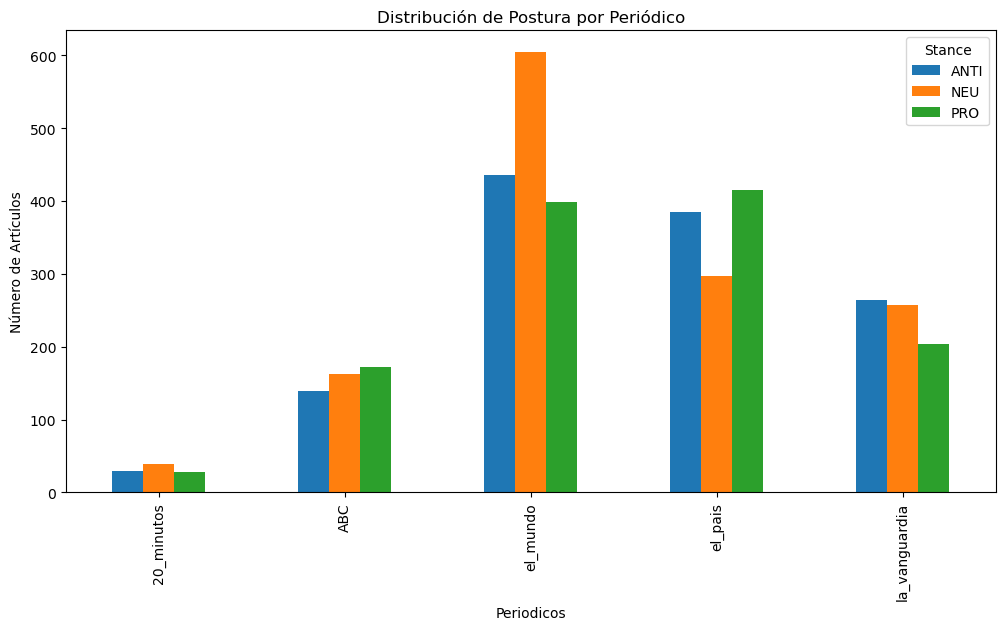

In [14]:
# Plot stance per newspaper
stance_per_newspaper.plot(kind="bar", figsize=(12,6), stacked=False)
plt.xlabel("Periodicos")
plt.ylabel("Número de Artículos")
plt.title("Distribución de Postura por Periódico")
plt.legend(title="Stance")
plt.show()


## N.E.R

In [15]:
# Function to Extract Named Entities
import spacy 
nlp = spacy.load("es_core_news_sm")
def extract_entities(text):
    doc = nlp(text)
    persons = [ent.text for ent in doc.ents if ent.label_ == "PER"]
    locations = [ent.text for ent in doc.ents if ent.label_ == "LOC"]
    organizations = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
    
    return persons, locations, organizations

# Apply function to all articles
df["persons"], df["locations"], df["organizations"] = zip(*df["clean_text"].apply(extract_entities))

# Print first 10 results
print(df[["clean_text", "persons", "locations", "organizations"]].head(10))



                                          clean_text  \
0  presidente joe biden terminando mandato todaví...   
1  vida sucede línea recta veces enmaraña luchar ...   
2  saliendo chicos mayores después tiempo centro ...   
3  mismo día lalachus mostró estampa vaquilla gra...   
4  primer disparo batalla donald trump ciudades s...   
5  cámara representantes aprobó martes proyecto l...   
6  rescate madre migrante hijo nacido travesía ru...   
7  refugios organizaciones brindan atención migra...   
8  papa francisco elegido cardenal robert mcelroy...   
9  niños migrantes méxico cada vez comunes último...   

                                             persons  \
0  [presidente, joe biden, donald trump, salvador...   
1  [vivió empezó, brille, ponía profesión, brille...   
2  [hortaleza relato, oposición, gil portavoz, ad...   
3  [grand prix, mahmoud bakhum, mahmoud murió, je...   
4             [llegó, stephen miller, jim mcdonnell]   
5  [antonio ibarra recibió, john fetterman, mik

In [16]:
from collections import Counter

#  Count top 10 most mentioned entities
top_persons = Counter([person for sublist in df["persons"] for person in sublist]).most_common(10)
top_locations = Counter([loc for sublist in df["locations"] for loc in sublist]).most_common(10)
top_organizations = Counter([org for sublist in df["organizations"] for org in sublist]).most_common(10)

#  Print results
print(" Most Mentioned Persons:", top_persons)
print(" Most Mentioned Locations:", top_locations)
print(" Most Mentioned Organizations:", top_organizations)


 Most Mentioned Persons: [('pedro', 596), ('fernando', 305), ('llegó', 251), ('donald trump', 186), ('donald', 184), ('harris', 163), ('von der', 155), ('joe biden', 141), ('fernando grandemarlaska', 124), ('matteo salvini', 82)]
 Most Mentioned Locations: [('europa', 1461), ('italia', 769), ('madrid', 752), ('canarias', 747), ('alemania', 527), ('francia', 466), ('ceuta', 450), ('marruecos', 371), ('barcelona', 363), ('eeuu', 357)]
 Most Mentioned Organizations: [('pp', 1507), ('ue', 969), ('psoe', 768), ('onu', 126), ('ningún', 108), ('otan', 81), ('psc', 79), ('oim', 70), ('pnv', 66), ('vox', 58)]


In [17]:
# Function to Extract Named Entities
import spacy 
nlp = spacy.load("es_core_news_sm")
def extract_entities(text):
    doc = nlp(text)
    persons = [ent.text for ent in doc.ents if ent.label_ == "PER"]
    locations = [ent.text for ent in doc.ents if ent.label_ == "LOC"]
    organizations = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
    
    return persons, locations, organizations

# Apply function to all articles
df["persons_2"], df["locations_2"], df["organizations_2"] = zip(*df["text"].apply(extract_entities))

# Print first 10 results
print(df[["clean_text", "persons_2", "locations_2", "organizations_2"]].head(10))

                                          clean_text  \
0  presidente joe biden terminando mandato todaví...   
1  vida sucede línea recta veces enmaraña luchar ...   
2  saliendo chicos mayores después tiempo centro ...   
3  mismo día lalachus mostró estampa vaquilla gra...   
4  primer disparo batalla donald trump ciudades s...   
5  cámara representantes aprobó martes proyecto l...   
6  rescate madre migrante hijo nacido travesía ru...   
7  refugios organizaciones brindan atención migra...   
8  papa francisco elegido cardenal robert mcelroy...   
9  niños migrantes méxico cada vez comunes último...   

                                           persons_2  \
0  [Joe Biden, Donald Trump, Nicolás Maduro, Madu...   
1  [Más, Paloma Sánchez-Garnica, vivió, Empezó De...   
2  [Lorena Morales, según, Elena Gil, Presupuesto...   
3  [Lalachus, Jesús, Mahmoud Bakhum, Mahmoud, Jes...   
4  [Donald Trump, llegó, Stephen Miller, Miller, ...   
5  [Donald Trump, Además, Laken Riley, Pennsylv

In [18]:
from collections import Counter

#  Count top 10 most mentioned entities
top_persons = Counter([person for sublist in df["persons_2"] for person in sublist]).most_common(10)
top_locations = Counter([loc for sublist in df["locations_2"] for loc in sublist]).most_common(10)
top_organizations = Counter([org for sublist in df["organizations_2"] for org in sublist]).most_common(10)

#  Print results
print(" Most Mentioned Persons:", top_persons)
print(" Most Mentioned Locations:", top_locations)
print(" Most Mentioned Organizations:", top_organizations)

 Most Mentioned Persons: [('España', 1383), ('Trump', 1352), ('Según', 802), ('Pedro Sánchez', 692), ('También', 648), ('Además', 611), ('Junts', 597), ('Así', 580), ('Donald Trump', 576), ('Salvamento Marítimo', 468)]
 Most Mentioned Locations: [('Gobierno', 2133), ('Canarias', 1941), ('España', 1811), ('Europa', 1420), ('Ceuta', 1033), ('Estados Unidos', 989), ('Marruecos', 957), ('Italia', 851), ('Madrid', 838), ('Estado', 815)]
 Most Mentioned Organizations: [('PP', 2435), ('Vox', 1542), ('UE', 1044), ('PSOE', 910), ('Guardia Civil', 615), ('Congreso', 590), ('Unión Europea', 539), ('Cruz Roja', 314), ('ERC', 258), ('Comisión Europea', 249)]


### COMPARISON BETWEEN DIFFERENT N.E.R ANALYSIS

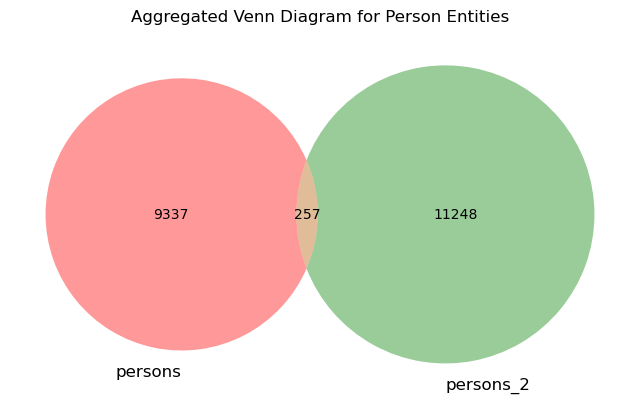

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Aggregate all entities from each column (union over all rows)
set_persons = set().union(*df['persons'])
set_persons_2 = set().union(*df['persons_2'])

# Create a Venn diagram
plt.figure(figsize=(8,8))
venn2([set_persons, set_persons_2],
      set_labels=('persons', 'persons_2'))
plt.title("Aggregated Venn Diagram for Person Entities")
plt.show()

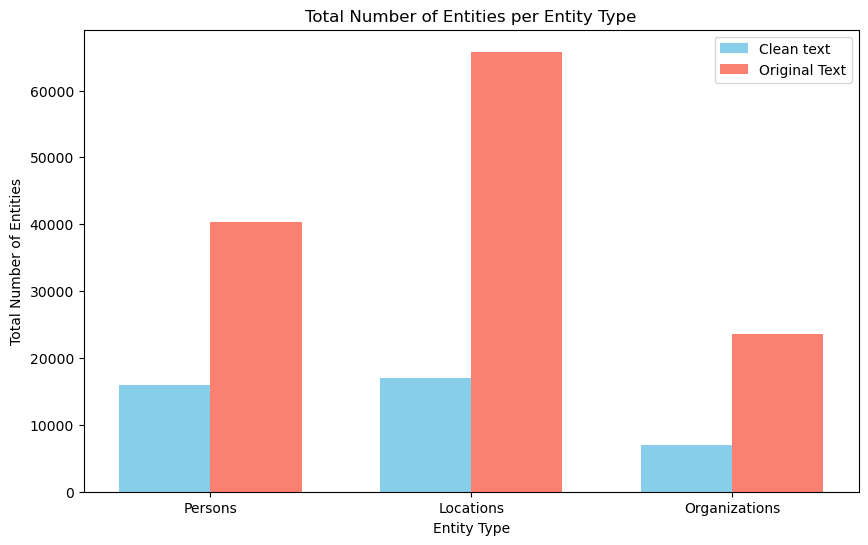

In [43]:
import numpy as np

# Count the total number of entities in each column by summing lengths of lists
persons_total = df['persons'].apply(len).sum()
persons_2_total = df['persons_2'].apply(len).sum()
locations_total = df['locations'].apply(len).sum()
locations_2_total = df['locations_2'].apply(len).sum()
organizations_total = df['organizations'].apply(len).sum()
organizations_2_total = df['organizations_2'].apply(len).sum()

# Group the counts by entity type
# For Persons, Locations, and Organizations, each with two methods
group_names = ['Persons', 'Locations', 'Organizations']
method1_counts = [persons_total, locations_total, organizations_total]
method2_counts = [persons_2_total, locations_2_total, organizations_2_total]

# Create positions for grouped bars
x = np.arange(len(group_names))  # positions for groups
width = 0.35  # width of each bar

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bar for first method (e.g. original)
bars1 = ax.bar(x - width/2, method1_counts, width, label='Clean text', color='skyblue')
# Bar for second method (e.g. alternative variant)
bars2 = ax.bar(x + width/2, method2_counts, width, label='Original Text', color='salmon')

# Labels and title
ax.set_xlabel('Entity Type')
ax.set_ylabel('Total Number of Entities')
ax.set_title('Total Number of Entities per Entity Type')
ax.set_xticks(x)
ax.set_xticklabels(group_names)
ax.legend()


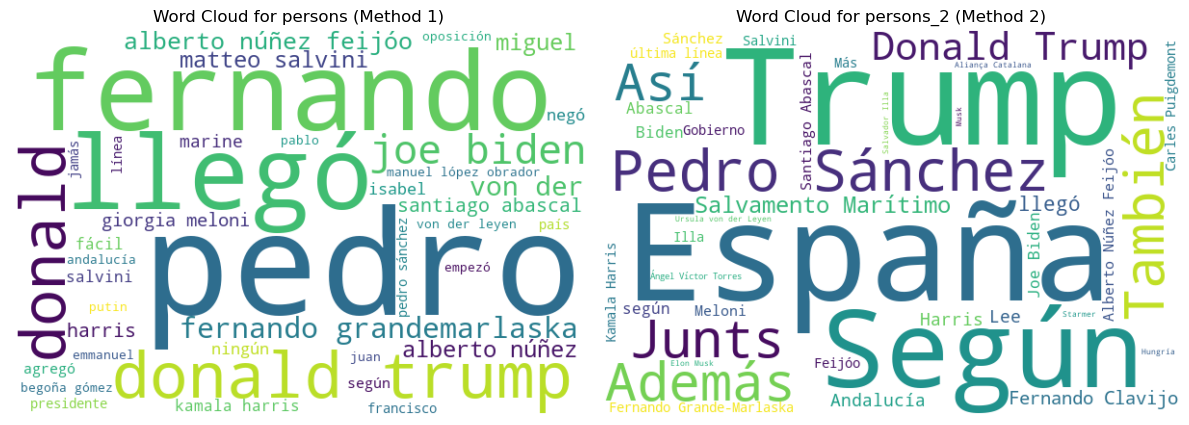

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

# Flatten the lists of entities for each method (for example, persons)
persons_method1 = [entity for sublist in df['persons'] for entity in sublist]
persons_method2 = [entity for sublist in df['persons_2'] for entity in sublist]

# Count frequency of each entity
counter1 = Counter(persons_method1)
counter2 = Counter(persons_method2)

# Get top 10 most common entities (if there are less than 10, it will take all)
top10_method1 = dict(counter1.most_common(40))
top10_method2 = dict(counter2.most_common(40))

# Generate word clouds from these frequencies
wc1 = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(top10_method1)
wc2 = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(top10_method2)

# Plot side-by-side word clouds for visual comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(wc1, interpolation='bilinear')
axes[0].set_title('Word Cloud for persons (Method 1)')
axes[0].axis('off')

axes[1].imshow(wc2, interpolation='bilinear')
axes[1].set_title('Word Cloud for persons_2 (Method 2)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## WORD EMBEDDINGS

In [50]:
from gensim.models import Word2Vec

# Tokenize articles into words
df["tokens"] = df["clean_text"].apply(lambda x: x.split())

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=df["tokens"], vector_size=100, window=5, min_count=5, workers=4)

# Save the model for later use
word2vec_model.save("word2vec_news.model")

print("✅ Word2Vec Model Trained and Saved!")
# 

✅ Word2Vec Model Trained and Saved!


In [51]:
import numpy as np

# Function to Convert Articles into Word2Vec Vectors
def get_article_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)  # Average the word vectors
    else:
        return np.zeros(model.vector_size)  # If no words match, return a zero vector

# Apply the function to all articles
df["vector"] = df["tokens"].apply(lambda tokens: get_article_vector(tokens, word2vec_model))

print("✅ Word2Vec Embeddings Ready!")


✅ Word2Vec Embeddings Ready!


In [52]:
# Load the trained Word2Vec model
word2vec_model = Word2Vec.load("word2vec_news.model")

# Find words similar to 'inmigrante'
print("Words similar to 'inmigrante':", word2vec_model.wv.most_similar("inmigrante"))

# Find words similar to 'crisis'
print("Words similar to 'crisis':", word2vec_model.wv.most_similar("crisis"))
# 

Words similar to 'inmigrante': [('migrante', 0.8317269086837769), ('residente', 0.8038486838340759), ('contable', 0.7863066792488098), ('pobre', 0.7791873812675476), ('cónyuge', 0.7702988386154175), ('persona', 0.7660752534866333), ('crecer', 0.7619068622589111), ('mejores', 0.7592446208000183), ('extranjero', 0.7524089813232422), ('vivir', 0.7501049041748047)]
Words similar to 'crisis': [('presión', 0.8986733555793762), ('política', 0.7571591734886169), ('precedentes', 0.7499997615814209), ('oleada', 0.7367166876792908), ('sufre', 0.7263066172599792), ('covid', 0.7200074195861816), ('pandemia', 0.7132017016410828), ('acapara', 0.7006561756134033), ('provocado', 0.6984710097312927), ('tensión', 0.6630381345748901)]


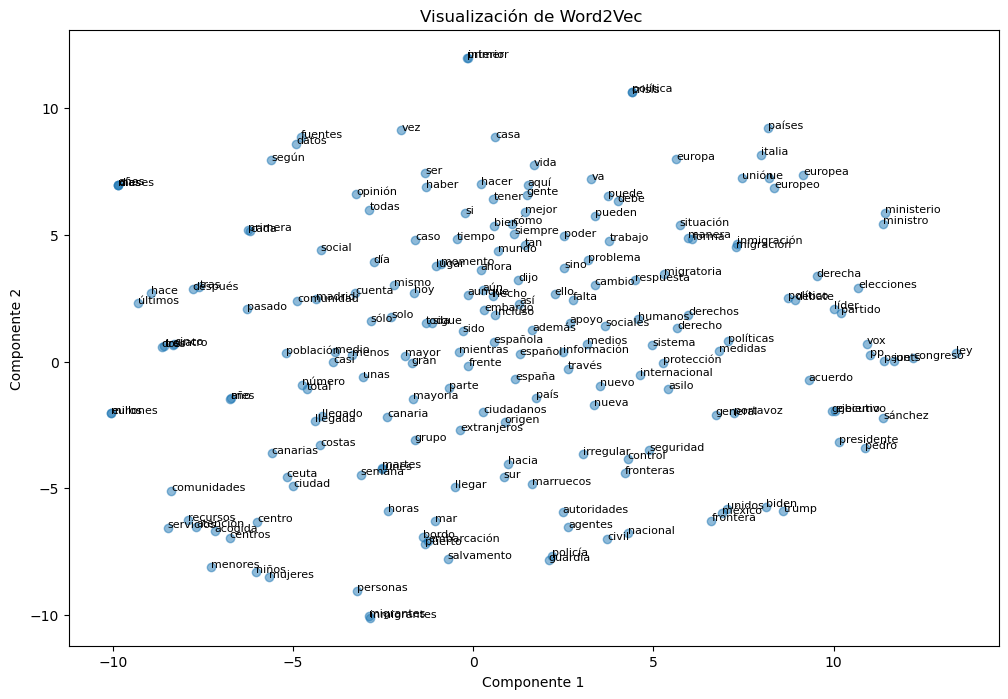

In [53]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Get the vocabulary words
words = list(word2vec_model.wv.index_to_key)[:200]  # Limit to 200 words for clarity
word_vectors = np.array([word2vec_model.wv[word] for word in words])

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plot the words in 2D space
plt.figure(figsize=(12, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], alpha=0.5)

# Annotate words
for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=8)

plt.title("Visualización de Word2Vec ")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()


# CLUSTERING


In [54]:
from sklearn.cluster import KMeans

# Stack vectors into a matrix for clustering
X = np.stack(df["vector"].values)

# Define number of clusters (you can adjust this)
num_clusters = 2  # We assume 2 clusters: "biased" vs "neutral"

# Train K-Means model
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X)

print("✅ K-Means Clustering Completed!")


✅ K-Means Clustering Completed!


In [55]:
from collections import Counter

#  Get most common words per cluster
for cluster_id in range(num_clusters):
    words = [word for tokens in df[df["cluster"] == cluster_id]["tokens"] for word in tokens]
    most_common_words = Counter(words).most_common(20)
    print(f"Common words in Cluster {cluster_id}:")
    print(most_common_words)
    print("\n")
# 

Common words in Cluster 0:
[('personas', 1703), ('migrantes', 1127), ('inmigrantes', 1121), ('dos', 911), ('embarcación', 759), ('horas', 757), ('salvamento', 735), ('según', 732), ('canarias', 693), ('marítimo', 656), ('bordo', 605), ('puerto', 602), ('sido', 596), ('cayuco', 560), ('menores', 555), ('canaria', 553), ('guardia', 543), ('gran', 512), ('año', 504), ('civil', 490)]


Common words in Cluster 1:
[('gobierno', 5962), ('personas', 4891), ('inmigración', 4432), ('si', 4296), ('país', 4202), ('años', 3933), ('inmigrantes', 3784), ('migrantes', 3605), ('españa', 3581), ('ser', 3130), ('menores', 2940), ('política', 2820), ('dos', 2784), ('países', 2604), ('presidente', 2584), ('año', 2583), ('según', 2526), ('pp', 2469), ('trump', 2419), ('parte', 2338)]




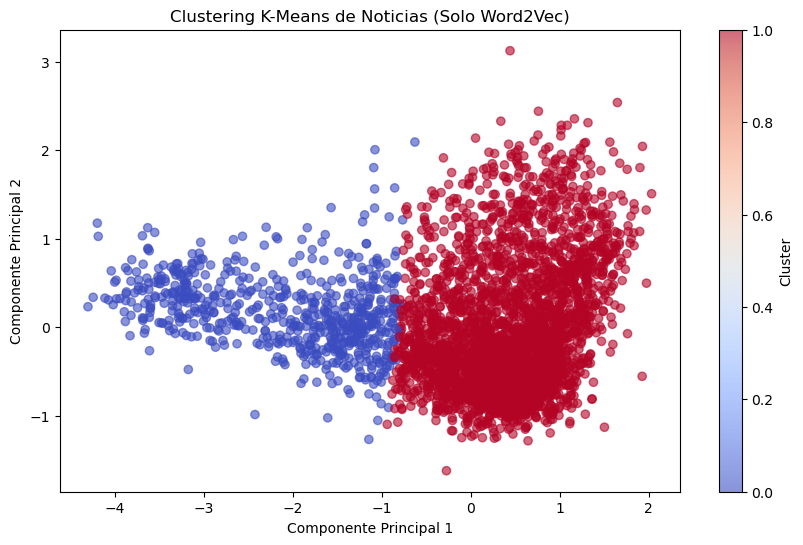

In [56]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions to 2D

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

#  Scatter plot of clusters
plt.figure(figsize=(10,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df["cluster"], cmap="coolwarm", alpha=0.6)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Clustering K-Means de Noticias (Solo Word2Vec)")
plt.colorbar(label="Cluster")
plt.show()


In [57]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Encode stance as numerical values (NEU = 0, PRO = 1, ANTI = -1)
stance_mapping = {"NEU": 0, "PRO": 1, "ANTI": -1}
df["stance_encoded"] = df["stance"].map(stance_mapping)

# Convert NER columns to numeric counts
df["num_persons"] = df["persons"].apply(len)
df["num_locations"] = df["locations"].apply(len)
df["num_organizations"] = df["organizations"].apply(len)

# Stack word2vec vectors
X_word2vec = np.stack(df["vector"].values)

# Combine Word2Vec with other features
X_extra = df[["sentiment_score", "stance_encoded", "pro_immigration_count", "anti_immigration_count", 
              "num_persons", "num_locations", "num_organizations"]].values

# Scale extra features
scaler = StandardScaler()
X_extra_scaled = scaler.fit_transform(X_extra)

# Concatenate word embeddings with scaled extra features
X_final = np.hstack([X_word2vec, X_extra_scaled])

print(f"✅ Final Feature Matrix Shape: {X_final.shape}")


✅ Final Feature Matrix Shape: (3832, 107)


In [58]:
from sklearn.cluster import KMeans

# Define number of clusters
num_clusters = 2  # Assuming "biased" vs "neutral"

# Train K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_final)

print("✅ K-Means Clustering Completed with Extra Features!")


✅ K-Means Clustering Completed with Extra Features!


In [59]:
from collections import Counter

#  Get most common words per cluster
for cluster_id in range(num_clusters):
    words = [word for tokens in df[df["cluster"] == cluster_id]["tokens"] for word in tokens]
    most_common_words = Counter(words).most_common(20)
    print(f"Common words in Cluster {cluster_id}:")
    print(most_common_words)
    print("\n")


Common words in Cluster 0:
[('personas', 3458), ('inmigrantes', 2302), ('migrantes', 1976), ('dos', 1828), ('años', 1746), ('si', 1677), ('gobierno', 1616), ('españa', 1566), ('según', 1550), ('inmigración', 1519), ('país', 1401), ('año', 1337), ('ser', 1311), ('menores', 1251), ('sido', 1227), ('tras', 1162), ('pasado', 1048), ('horas', 1045), ('canarias', 1041), ('parte', 1015)]


Common words in Cluster 1:
[('gobierno', 4741), ('personas', 3136), ('inmigración', 3133), ('país', 2950), ('si', 2791), ('migrantes', 2756), ('inmigrantes', 2603), ('años', 2430), ('españa', 2314), ('menores', 2244), ('pp', 2241), ('política', 2186), ('ser', 2135), ('países', 2067), ('presidente', 2016), ('dos', 1867), ('año', 1750), ('según', 1708), ('ley', 1692), ('partido', 1679)]




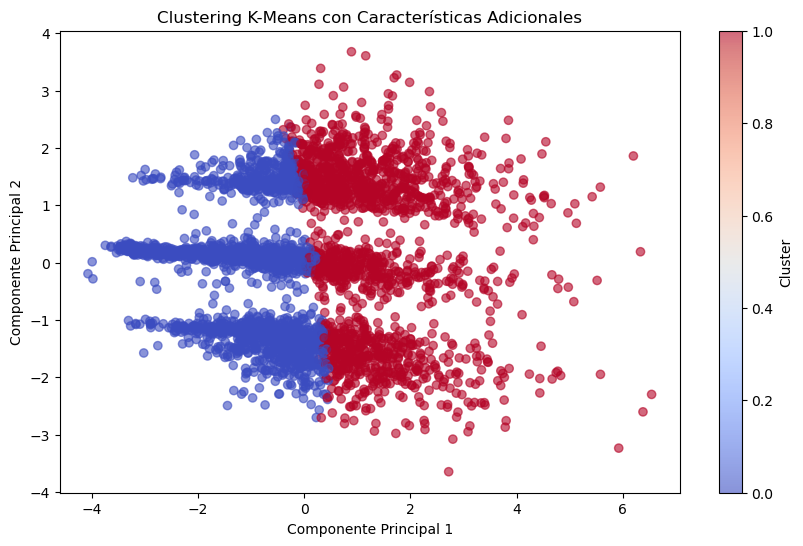

In [60]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_final)

# Scatter plot of clusters
plt.figure(figsize=(10,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df["cluster"], cmap="coolwarm", alpha=0.6)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Clustering K-Means con Características Adicionales")
plt.colorbar(label="Cluster")
plt.show()


In [61]:
import pandas as pd

# Check stance distribution per cluster
stance_vs_cluster = df.groupby("cluster")["stance"].value_counts(normalize=True).unstack()
print("Distribución de stance por cluster:")
print(stance_vs_cluster)

# Check sentiment distribution per cluster
sentiment_vs_cluster = df.groupby("cluster")["sentiment"].value_counts(normalize=True).unstack()
print("\nDistribución de sentimiento por cluster:")
print(sentiment_vs_cluster)


Distribución de stance por cluster:
stance       ANTI       NEU       PRO
cluster                              
0        0.362679  0.458852  0.178469
1        0.284730  0.230195  0.485075

Distribución de sentimiento por cluster:
sentiment       NEG       NEU       POS
cluster                                
0          0.057416  0.880861  0.061722
1          0.048794  0.768657  0.182549


In [62]:
# Check which newspapers dominate each cluster
newspaper_vs_cluster = df.groupby("cluster")["newspaper"].value_counts(normalize=True).unstack()
print("\nDistribución de periódicos por cluster:")
print(newspaper_vs_cluster)



Distribución de periódicos por cluster:
newspaper  20_minutos       ABC  el_mundo   el_pais  la_vanguardia
cluster                                                           
0             0.03110  0.126794  0.506220  0.190909       0.144976
1             0.01837  0.119403  0.218714  0.400689       0.242824


EVALUATION METRICS K-MEANS

Model 1 (Word2Vec Only):
  Silhouette Score: 0.366
  Inertia: 7979.834

Model 2 (Word2Vec + Extra Features):
  Silhouette Score: 0.152
  Inertia: 32410.921


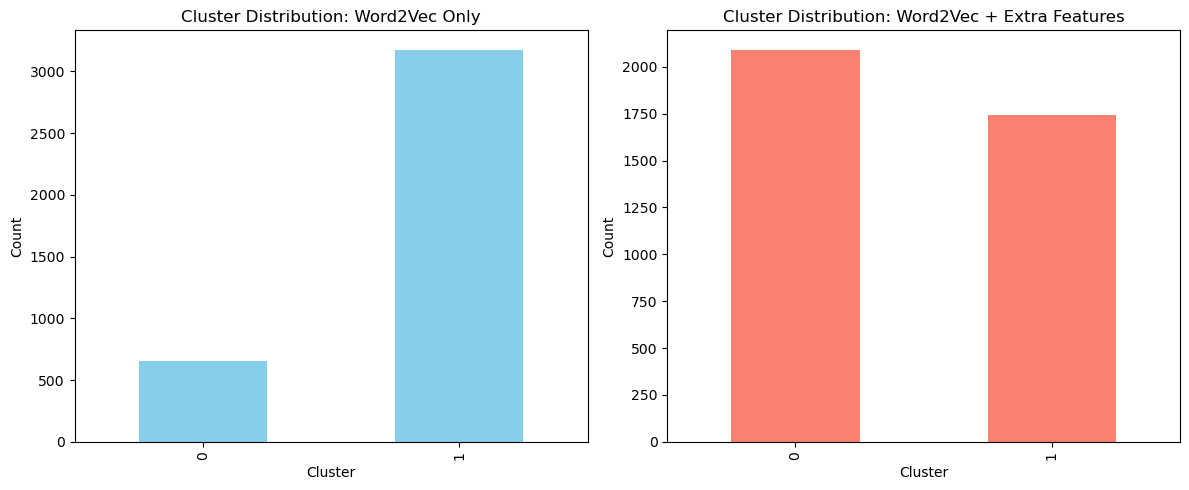

In [65]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Example setup: assuming df already has necessary columns and features
# Dummy data for demonstration; replace with your actual DataFrame and vectors.
# -----------------------------------------------------
# Model 1: clustering on Word2Vec vectors only
# Stack word2vec vectors into a matrix for clustering
X_word2vec = np.stack(df["vector"].values)  # shape: (num_samples, vector_dim)

# Define number of clusters (for example, 2: "biased" vs "neutral")
num_clusters = 2

# Train K-Means model on Word2Vec vectors only
kmeans_word2vec = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters_word2vec = kmeans_word2vec.fit_predict(X_word2vec)

# Compute metrics for Model 1
silhouette_word2vec = silhouette_score(X_word2vec, clusters_word2vec)
inertia_word2vec = kmeans_word2vec.inertia_

# -----------------------------------------------------
# Model 2: clustering on Word2Vec vectors + extra features
# Prepare extra features and scale them
X_extra = df[["sentiment_score", "stance_encoded", "pro_immigration_count", "anti_immigration_count", 
              "num_persons", "num_locations", "num_organizations"]].values
scaler = StandardScaler()
X_extra_scaled = scaler.fit_transform(X_extra)

# Concatenate word embeddings with scaled extra features
X_final = np.hstack([X_word2vec, X_extra_scaled])

# Train K-Means on combined features
kmeans_final = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters_final = kmeans_final.fit_predict(X_final)

# Compute metrics for Model 2
silhouette_final = silhouette_score(X_final, clusters_final)
inertia_final = kmeans_final.inertia_

# -----------------------------------------------------
# Print and compare the results
print("Model 1 (Word2Vec Only):")
print(f"  Silhouette Score: {silhouette_word2vec:.3f}")
print(f"  Inertia: {inertia_word2vec:.3f}")

print("\nModel 2 (Word2Vec + Extra Features):")
print(f"  Silhouette Score: {silhouette_final:.3f}")
print(f"  Inertia: {inertia_final:.3f}")

# Optionally, you can also add the cluster assignments to your DataFrame for further analysis:
df["cluster_word2vec"] = clusters_word2vec
df["cluster_final"] = clusters_final

# Plotting cluster counts for visual comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

df["cluster_word2vec"].value_counts().sort_index().plot(kind="bar", ax=ax[0], color="skyblue")
ax[0].set_title("Cluster Distribution: Word2Vec Only")
ax[0].set_xlabel("Cluster")
ax[0].set_ylabel("Count")

df["cluster_final"].value_counts().sort_index().plot(kind="bar", ax=ax[1], color="salmon")
ax[1].set_title("Cluster Distribution: Word2Vec + Extra Features")
ax[1].set_xlabel("Cluster")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()
